In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

In [38]:
ffamilies = [
    lambda k: lambda x: x[0, 0]**2 + k * x[0, 0] * x[0, 1] + x[0,1]**2, # x^2 + kxy + y^2
    lambda k: lambda x: (k+1) * x[0, 0]**2 + x[0,1]**3,          # k x^2 + y^3
]

In [39]:
def partial(f, x, i=[0], dx=1e-6):
    """Computes the i-th partial derivative of f at point x.
    
    Args:
        f: objective function.
        x: point at which partial derivative is computed.
        i: list of coordinates along which derivative is computed (differentiates successively once per coordinate).
        dx: slack for finite difference.
        
    Output:
        (float)
    """
    if not i:
        return f(x)
    x = x.reshape(1, -1)
    h = np.zeros(x.shape)
    h[0, i[0]] = dx
    p1 = partial(f, x + h, i[1:], dx)
    p2 = partial(f, x - h, i[1:], dx)
    return (p1 - p2) / (2*dx)

def deriv1(f, x, i, dx=1e-6):
    return partial(f, x, [i], dx)

def deriv2(f, x, i, j, dx=1e-6):
    return partial(f, x, [i, j], dx)

In [40]:
def gradient(f, x, dx=1e-6):
    """Computes gradient of f at point x.
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of size domain of f.
    """
    x = x.reshape(1, -1)
    dim = x.shape[1]
    return np.array([deriv1(f, x, i, dx) for i in range(dim)]).reshape(1, -1)

def hessian(f ,x, dx=1e-6):
    """Computes hessian of f at point x.
    
    Args:
        f: objective function.
        x: point at which hessian is computed.
        dx: slack for finite difference of partial derivatives.
        
    Output:
        (ndarray) of square shape and size domain of f.
    """
    x = x.reshape(1, -1)
    dim = x.shape[1]
    line = lambda i: np.array([deriv2(f, x, i, j, dx) for j in range(dim)])
    return np.array([line(i) for i in range(dim)])

# Nombre de conditionnement : rapport entre la plus grande et la
# plus petite des courbures parmi les directions partant de x.
def condition_number(f, x):
    H = hessian(f, x)
    eivals, _ = np.linalg.eig(H)
    return abs(max(eivals) / min(eivals))

In [42]:
i, k, x = 1, 2, np.r_[100, 100]
hessian(ffamilies[i](k), x), condition_number(ffamilies[i](k), x)
for i in range(15):
    print(condition_number(ffamilies[1](i), x))

inf
inf
21.0
inf
11.356388279456786
11.356388279456786
101.99019513592752
101.99019513592752
101.99019513592752
inf
101.99019513592752
inf
inf
101.99019513592752
101.99019513592752


/usr/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


In [30]:
class ClassicUpdater:
    def __init__(self, rate=0.01, tol=1e-6):
        self.rate = rate if callable(rate) else lambda reset: rate
        self.tol = tol

    def __call__(self, f, x, reset):
        return self.rate(reset) * -gradient(f, x, self.tol)

ln_decay = lambda n: lambda tol: lambda f, x: np.linalg.norm(gradient(f, x, tol), ord=n)
l1_decay = ln_decay(1)
l2_decay = ln_decay(2)

class GD():
    """Gradient Descent Object.
    
    Implements gradient descent aiming to compute optimal objective 
    value of convex functions and local optimal ones of none 
    convex functions.
    """    
    def __init__(self, delta=None, decay=None, tol=1e-6, max_iter=1000):
        """
        Instantiates a GD object.
    
        Attributes:
        delta: function computing descent update vector (direction + step)
        decay: function computing decay
        tol: slack tolerance.
        max_iter: upper bound on number of iterations.
        """
        self.delta = delta if delta is not None else ClassicUpdater(0.01, tol)
        self.decay = decay if decay is not None else l2_decay(tol)
        self.tol = tol
        self.max_iter = max_iter
        self.grad = gradient
    
    def __call__(self, x, f):
        """Calling gradient descent object with specific starting point and optimal function.
        
        Args:
            x: initial starting point for descent.
            f: objective function of optimisation problem.
        
        Output:
            (float) sub-optimal value up to tolerance if execution is proper.
            (ndarray) list of gradient descent iterates.
        """
        # Helper functions
        compute_delta = lambda x, reset=False: self.delta(f, x, reset)
        compute_decay = lambda x: self.decay(f, x)
        
        # Start
        x = x.reshape(1, -1)
        n_iter = 0
        iters, iters_dir = x, compute_delta(x, reset=True)
        decay = compute_decay(x)
        while decay > self.tol and n_iter < self.max_iter:
            ## Decide on direction
            delta = compute_delta(x)
            ## Update iterate
            x = x + delta
            ## Store on-going data
            iters = np.vstack([iters, x])
            iters_dir = np.vstack([iters_dir, delta])
            ## Update decay
            decay = compute_decay(x)
            ## Update iteration number
            n_iter += 1

        # Display results
        msg = " Iteration nu. = {}\n approx. = {}\n ob value = {}\n and decay = {}."
        #print(msg.format(n_iter, x.flatten(), f(x), decay))
        if decay > self.tol:
            warnings.warn("Decay didn't get under tolerance rate.", RuntimeWarning)
        return (x, iters, iters_dir, n_iter) 

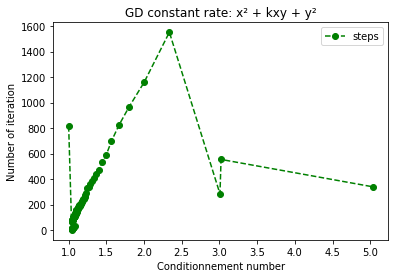

In [36]:
def plot_gradient_descent(f, x, k_max, str_name, rate=0.01, max_cond=100, max_iter_per_gd=2000):
    """Plot the number iterations of a constant gradient descent of f at point x with several k,
       contrasted with the conditionnement number
    
    Args:
        f: objective function.
        x: point at which gradient is computed.
        k_max: number of k (0 to k_max)
        str_name: string name of the function
    """
    DG_classic = GD(ClassicUpdater(rate=rate), max_iter=max_iter_per_gd)

    list_iter = [DG_classic(x, f(k))[3] for k in range(k_max)]
    list_cond = [condition_number(f(k), x) for k in range(k_max)]

    array_cond = np.array(list_cond)
    array_iter = np.array(list_iter)

    array_tuple = list(filter(lambda tup: tup[0] < max_cond, zip(array_cond, array_iter)))
    array_tuple.sort(key=lambda tup: tup[0])

    array_cond_iter = list(zip(*array_tuple))

    plt.plot(array_cond_iter[0], array_cond_iter[1], "--go", label="steps")
    plt.legend(loc='upper right')
    plt.xlabel("Conditionnement number")
    plt.ylabel("Number of iteration")
    plt.title("GD constant rate: " + str_name)

    plt.show()
    
plot_gradient_descent(ffamilies[0], np.r_[5, 5], 100, "x² + kxy + y²")

In [ ]:
DG_classic = GD()
DG_classic(np.r_[1, 1], ffamilies[0](0))
print()

In [ ]:
class ExponentialLRScheduler:
    def __init__(self, initial_rate=0.1, r=0.1):
        self.initial_rate = initial_rate
        self.r = r

    def __call__(self, reset):
        if reset:
            self.n_iter = 0
        return self.initial_rate * 10**(- self.n_iter / self.r)

In [ ]:
DG_classic = GD(ClassicUpdater(ExponentialLRScheduler()))
DG_classic(np.r_[15, 20], ffamilies[0](0))
print()

In [ ]:
class NesterovUpdater:
    def __init__(self, rate=0.01, momentum=0.9, tol=1e-6):
        self.rate = rate
        self.momentum = momentum
        self.tol = tol
    
    def __call__(self, f, x, reset):
        x = x.reshape(1, -1)
        if reset is True:
            self.m_vect = np.zeros(x.shape[1])
        mv = self.momentum * self.m_vect
        self.m_vect = mv - self.rate * gradient(f, x + mv, self.tol)
        return self.m_vect

class AdamUpdater:
    def __init__(self, rate=0.01, beta1=0.9, beta2=0.9, tol=1e-6, epsilon=1e-7):
        self.rate = rate
        self.beta1 = beta1
        self.beta2 = beta2
        self.tol = tol
        self.epsilon = epsilon

    def __call__(self, f, x, reset):
        x = x.reshape(1, -1)
        if reset is True:
            self.n_iter = 1
            self.m_vect = np.zeros(x.shape[1])
            self.s_vect = np.zeros(x.shape[1])
        gf = gradient(f, x, self.tol)
        m = self.beta1 * self.m_vect - (1 - self.beta1) * gf
        s = self.beta2 * self.s_vect + (1 - self.beta2) * gf * gf
        self.m_vect = m / (1 - self.beta1**self.n_iter)
        self.s_vect = s / (1 - self.beta2**self.n_iter)
        return self.rate * self.m_vect / np.sqrt(self.s_vect + self.epsilon)

In [ ]:
DG_nesterov = GD(NesterovUpdater())
DG_nesterov(np.r_[15, 20], ffamilies[0](0))
print()
DG_adam = GD(AdamUpdater())
DG_adam(np.r_[15, 20], ffamilies[0](0))
print()

In [57]:
def newton(f, x, rate=0.1, tol=1e-6):
    """Computes a local minimum of f at point x using Newton's method.
    
    Args:
        f: objective function.
        x: starting point
        tol: tolerance used for hessian computation and stop condition
        
    Output:
        (ndarray) of the same shape as x.
    """
    lamda = 2.0 * tol + 1
    n_iter = 0
    while lamda/2 > tol:
        delta = np.linalg.inv(hessian(f, x, tol)) @ gradient(f, x, tol).T
        lamda = np.dot(gradient(f, x, tol), delta)
        x = x - rate * delta
        n_iter += 1
    return x, n_iter

In [58]:
newton(lambda x: x[0,0]**2 + x[0,1]**2, np.r_[5, 5])

LinAlgError: Singular matrix